In [97]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd


import glob
import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS, FREQ_GROUPS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

from cli import get_file_paths

In [136]:
def get_snr_from_band_limited_signal(snr_call_signal, snr_noise_signal): 

    signal_power = np.sqrt(np.square(snr_call_signal).mean())
    noise_power = np.sqrt(np.square(snr_noise_signal).mean())
    snr = abs(20 * np.log10(signal_power / noise_power))

    return snr

def bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff):
    nyq = fs // 2
    low_cutoff = (low_freq_cutoff) / nyq
    high_cutoff =  (high_freq_cutoff) / nyq
    b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
    band_limited_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

    return band_limited_audio_seg

def collect_call_snrs_from_bat_bout_in_audio_file(audio_file, bat_bout):
    fs = audio_file.samplerate
    nyquist = fs//2
    call_snrs = []
    for i, call in bat_bout.iterrows():
        call_dur = (call['end_time'] - call['start_time'])
        pad = 0.002
        start = call['start_time'] - call_dur - (3*pad)
        duration = (2 * call_dur) + (4*pad)
        end = call['end_time']
        if start >=0 and end <= 1795:
            audio_file.seek(int(fs*start))
            audio_seg = audio_file.read(int(fs*duration))
            
            low_freq_cutoff = call['low_freq']-2000
            high_freq_cutoff = call['high_freq']+2000
            if high_freq_cutoff < nyquist:
                band_limited_audio_seg = bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff)

                signal = band_limited_audio_seg.copy()
                signal[:int(fs*(call_dur+(2*pad)))] = 0

                noise = band_limited_audio_seg - signal

                snr_call_signal = signal[-int(fs*(call_dur+(2*pad))):]
                snr_noise_signal = noise[:int(fs*(call_dur+(2*pad)))]

                snr = get_snr_from_band_limited_signal(snr_call_signal, snr_noise_signal)
                call_snrs += [snr]
            else:
                call_snrs += [np.NaN]
        else:
            call_snrs += [np.NaN]

    return call_snrs


def get_bout_metrics_from_single_bd2_output(bd2_output, data_params, bout_params):
    # batdetect2_predictions = ss.simulate_dutycycle_on_detections(bd2_output, data_params['cur_dc_tag'])
    dc_tag = data_params['cur_dc_tag']
    cycle_length = int(dc_tag.split('of')[1])
    time_on = int(dc_tag.split('of')[0])

    bd2_output['ref_time'] = pd.DatetimeIndex(bd2_output['ref_time'])
    bd2_output['call_end_time'] = pd.DatetimeIndex(bd2_output['call_end_time'])
    bd2_output['call_start_time'] = pd.DatetimeIndex(bd2_output['call_start_time'])
    
    resampled_df = bd2_output.resample(f'{cycle_length}S', on='ref_time')
    bd2_output['ref_time'] = resampled_df['ref_time'].transform(lambda x: x.name)
    bd2_output.insert(0, 'end_time_wrt_ref', (bd2_output['call_end_time'] - bd2_output['ref_time']).dt.total_seconds())
    bd2_output.insert(0, 'start_time_wrt_ref', (bd2_output['call_start_time'] - bd2_output['ref_time']).dt.total_seconds())

    batdetect2_predictions = bd2_output.loc[bd2_output['end_time_wrt_ref'] <= time_on]
    batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
    bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)

    return bout_metrics

def collect_fft_spectra_from_calls_in_bout(audio_file, bat_bout, bucket):
    fs = audio_file.samplerate
    nyq = fs//2
    sampled_calls_from_bout = pd.DataFrame()

    for i, call in bat_bout.iterrows():
        call_dur = (call['end_time'] - call['start_time'])
        pad = 0.002
        start = call['start_time'] - call_dur - (3*pad)
        duration = (2 * call_dur) + (4*pad)
        end = call['end_time']
        if start >= 0 and end <= 1795:
            audio_file.seek(int(fs*start))
            audio_seg = audio_file.read(int(fs*duration))

            low_freq_cutoff = call['low_freq']-2000
            high_freq_cutoff = call['high_freq']+2000
            if high_freq_cutoff < nyq:
                band_limited_audio_seg = bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff)
                audio_spectrum = scipy.fft.rfft(band_limited_audio_seg, n=int(fs)-1)
                audio_spectrum = np.abs(audio_spectrum)
                audio_spectrum_db =  20*np.log10(audio_spectrum)
                normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

                thresh = -20
                peak_db = np.zeros(125000)+thresh
                peak_db[np.where(normalized_audio_spectrum_db>=thresh)[0]] = normalized_audio_spectrum_db[normalized_audio_spectrum_db>=thresh]

                bucket.append(peak_db)
                sampled_call = pd.DataFrame(columns=call.index)
                sampled_call.loc[len(sampled_call)] = call
                sampled_calls_from_bout = pd.concat([sampled_calls_from_bout, sampled_call], axis=0)

    return bucket, sampled_calls_from_bout

def collect_fft_spectra_from_calls_in_file(data_params, bout_params, bucket_for_location, calls_sampled_from_location):
    file_path = Path(data_params['audio_file'])
    csv_path = Path(data_params['csv_file'])

    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate

    bd2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)

    if len(bd2_predictions)>0:
        print(bd2_predictions)
        bout_metrics = get_bout_metrics_from_single_bd2_output(bd2_predictions, data_params, bout_params)
        bout_metrics.reset_index(inplace=True)
        if 'index' in bout_metrics.columns:
            bout_metrics.drop(columns='index', inplace=True)

        nyquist = fs//2
        bucket_for_file = []
        calls_sampled_from_file = pd.DataFrame()
        for bout_index, row in bout_metrics.iterrows():
            group = row['freq_group']
            freq_group = bd2_predictions.loc[bd2_predictions['freq_group']==group]
            bat_bout = freq_group.loc[(freq_group['start_time']>=row['start_time'])&(freq_group['end_time']<=row['end_time'])].copy()
            call_snrs = collect_call_snrs_from_bat_bout_in_audio_file(audio_file, bat_bout)

            bat_bout['SNR'] = call_snrs
            top_10_SNR =  0.90*bat_bout['SNR'].max()
            top_10_SNR_bat_bout = bat_bout.loc[bat_bout['SNR']>=top_10_SNR]
            bucket_for_file, sampled_calls_from_bout = collect_fft_spectra_from_calls_in_bout(audio_file, top_10_SNR_bat_bout, bucket_for_file)

            bat_bout_condensed = pd.DataFrame()
            bat_bout_condensed['bout_index'] = [bout_index]*len(sampled_calls_from_bout)
            bat_bout_condensed['SD Card'] = sampled_calls_from_bout['SD Card'].values
            bat_bout_condensed['File name'] = str(Path(sampled_calls_from_bout['input_file'].values[0]).name)
            bat_bout_condensed['Site'] = sampled_calls_from_bout['Site name'].values
            bat_bout_condensed['SNR'] = sampled_calls_from_bout['SNR'].values

            calls_sampled_from_file = pd.concat([calls_sampled_from_file, bat_bout_condensed])

        bucket_for_location.append(bucket_for_file)
        calls_sampled_from_location = pd.concat([calls_sampled_from_location, calls_sampled_from_file])

    return bucket_for_location, calls_sampled_from_location

def filter_df_with_location(ubna_data_df, site_name, start_time, end_time):
    site_name_cond = ubna_data_df["Site name"] == site_name

    file_year_cond = ubna_data_df.index.year == 2022
    minute_cond = np.logical_or((ubna_data_df.index).minute == 30, (ubna_data_df.index).minute == 0)
    datetime_cond = np.logical_and((ubna_data_df.index).second == 0, minute_cond)
    file_error_cond = np.logical_and((ubna_data_df["File duration"]!='File has no comment due to error!'), (ubna_data_df["File duration"]!='File has no Audiomoth-related comment'))
    all_errors_cond = np.logical_and((ubna_data_df["File duration"]!='Is empty!'), file_error_cond)

    filtered_location_df = ubna_data_df.loc[site_name_cond&datetime_cond&file_year_cond&all_errors_cond].sort_index()
    filtered_location_nightly_df = filtered_location_df.between_time(start_time, end_time, inclusive="left")

    return filtered_location_nightly_df

def get_params_relevant_to_data_at_location(cfg):
    data_params = dict()
    data_params['site'] = cfg['site']
    print(f"Searching for files from {cfg['site']}")

    drives_df = dd.read_csv(f'../data/ubna_data_*_collected_audio_records.csv', dtype=str).compute()
    drives_df.drop(columns='Unnamed: 0', inplace=True)
    drives_df["index"] = pd.DatetimeIndex(drives_df["Datetime UTC"])
    drives_df.set_index("index", inplace=True)
    
    files_from_location = filter_df_with_location(drives_df, data_params['site'], cfg['recording_start'], cfg['recording_end'])

    data_params['ref_audio_files'] = sorted(list(files_from_location["File path"].apply(lambda x : Path(x)).values))
    file_status_cond = files_from_location["File status"] == "Usable for detection"
    file_duration_cond = np.isclose(files_from_location["File duration"].astype('float'), 1795)
    good_location_df = files_from_location.loc[file_status_cond&file_duration_cond]
    data_params['good_audio_files'] = sorted(list(good_location_df["File path"].apply(lambda x : Path(x)).values))

    if data_params['good_audio_files'] == data_params['ref_audio_files']:
        print("All files from deployment session good!")
    else:
        print("Error files exist!")

    print(f"Will be looking at {len(data_params['good_audio_files'])} files from {data_params['site']}")

    return good_location_df, data_params

def sample_calls_and_generate_bucket_for_location(cfg):
    freq_key = ''
    bucket_for_location = []
    calls_sampled_from_location = pd.DataFrame()
    data_params = dict()
    data_params["type_tag"] = freq_key
    data_params["cur_dc_tag"] = "1800of1800"
    data_params["site_tag"] = cfg['site'] 
    data_params["site_name"] = SITE_NAMES[cfg['site']]

    file_paths = get_file_paths(data_params)
    location_sum_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
    bout_params = bt_clustering.get_bout_params_from_location(location_sum_df, data_params)
    csv_files_for_location = sorted(list(glob.glob(f'../data/raw/{data_params["site_tag"]}/**.csv')))

    good_location_df, data_params = get_params_relevant_to_data_at_location(cfg)
    site_filepaths = good_location_df['File path'].values

    for filepath in site_filepaths:
        print(filepath)
        data_params['audio_file'] = filepath
        filename = data_params['audio_file'].name.split('.')[0]
        csv_path = Path(f'../data/raw/{data_params["site_tag"]}/bd2__{data_params["site_tag"]}_{filename}.csv')
        data_params['csv_file'] = csv_path

        if data_params['csv_file'] in csv_files_for_location:
            bucket_for_location, calls_sampled_from_location = collect_fft_spectra_from_calls_in_file(data_params, bout_params, bucket_for_location, calls_sampled_from_location)

    bucket_for_location = np.vstack(bucket_for_location)

    np.save(f'2022_{data_params["site_tag"]}.npy', bucket_for_location)
    calls_sampled_from_location.to_csv(f'2022_{data_params["site_tag"]}.csv')

    return bucket_for_location, calls_sampled_from_location

In [137]:
cfg= dict()
cfg['site'] = 'Foliage'
cfg['recording_start'] = '02:00'
cfg['recording_end'] = '13:30'
cfg['hard_drive'] = 'ubna_data_02'

In [138]:
freq_key = ''
bucket_for_location = []
calls_sampled_from_location = pd.DataFrame()
data_params = dict()
data_params["type_tag"] = freq_key
data_params["cur_dc_tag"] = "1800of1800"
data_params["site_tag"] = cfg['site'] 
data_params["site_name"] = SITE_NAMES[cfg['site']]

file_paths = get_file_paths(data_params)
location_sum_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
bout_params = bt_clustering.get_bout_params_from_location(location_sum_df, data_params)
csv_files_for_location = sorted(list(glob.glob(f'../data/raw/{data_params["site_tag"]}/**.csv')))

site_filepaths = EXAMPLE_FILES_from_LOCATIONS[data_params["site_tag"]]

for filepath in site_filepaths:
    print(filepath)
    data_params['audio_file'] = EXAMPLE_FILES_to_FILEPATHS[filepath]
    filename = Path(data_params['audio_file']).name.split('.')[0]
    csv_path = Path(f'../data/raw/{data_params["site_tag"]}/bd2__{data_params["site_tag"]}_{filename}.csv')
    data_params['csv_file'] = csv_path

    if str(data_params['csv_file']) in csv_files_for_location:
        bucket_for_location, calls_sampled_from_location = collect_fft_spectra_from_calls_in_file(data_params, bout_params, bucket_for_location, calls_sampled_from_location)
        
bucket_for_location

UBNA_002/20220802_043000
UBNA_002/20220802_050000
UBNA_002/20220802_053000
UBNA_002/20220802_060000
UBNA_002/20220802_063000
UBNA_002/20220802_070000
UBNA_002/20220802_073000
UBNA_002/20220802_080000
UBNA_002/20220802_083000
UBNA_002/20220802_090000
UBNA_002/20220802_093000


[[array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20., -20., -20., ..., -20., -20., -20.]),
  array([-20

In [139]:

bucket_for_location = np.vstack(bucket_for_location)


In [ ]:

np.save(f'2022_{data_params["site_tag"]}.npy', bucket_for_location)
calls_sampled_from_location.to_csv(f'2022_{data_params["site_tag"]}.csv')

In [122]:
sample_calls_and_generate_bucket_for_location(cfg)

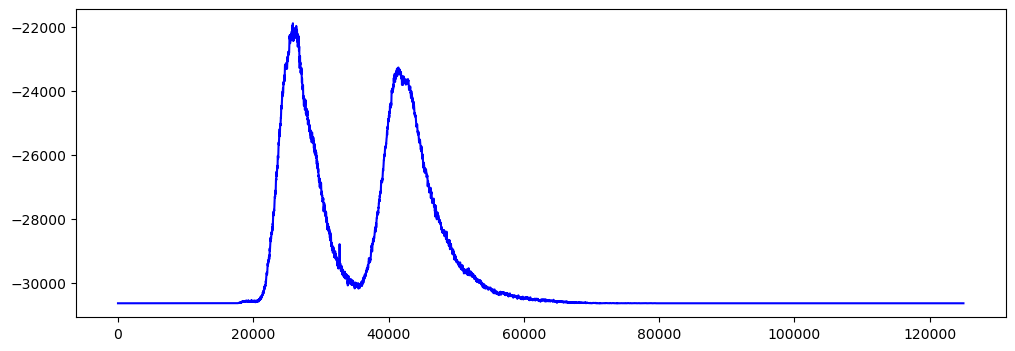

In [140]:
plt.figure(figsize=(12, 4))
plt.plot(np.sum(bucket_for_location, axis=0), color='blue', alpha = 1)
plt.show()